**Experiment 1 - Moving the IMU Device (Phone) on the table and getting trajectory**
 

I. Calculating Distance Covered 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Functions for Performing Double Integration of Accelerometer Data

In [4]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

def load_data(gyro_fname, accel_fname, time_acc):
    gyro = np.loadtxt(gyro_fname, delimiter=',')
    accel = np.loadtxt(accel_fname, delimiter=',')
    #groundtruth = np.loadtxt(groundtruth_fname, delimiter=',')
    timestamp_acc = np.loadtxt(time_acc, delimiter=',')
    return gyro,accel, timestamp_acc

def double_integration(vect_x, vect_y, vect_z, calibration, velocity_init, position_init, delta_t):
    taille_vect = len(vect_x)
    velocity_x = []
    velocity_y = []
    velocity_z = []
    
    position_x = []
    position_y = []
    position_z = []
    val = []
    for i in range(0,taille_vect):
        if (i == 0):
            #Attention a le faire plus proprement pour initialisation different de
            # X(0, 0,0) V(0, 0, 0)
            velocity_x.append(velocity_init[0])
            velocity_y.append(velocity_init[1])
            velocity_z.append(velocity_init[2])
            

            position_x.append(position_init[0])
            position_y.append(position_init[1])
            position_z.append(position_init[2])
        if (i == 1):
            velocity_x.append(integration_trapeze_init(velocity_init[0], i, vect_x, delta_t[i]))
            velocity_y.append(integration_trapeze_init(velocity_init[1], i, vect_y, delta_t[i]))
            velocity_z.append(integration_trapeze_init(velocity_init[2], i, vect_z, delta_t[i]))
            

            position_x.append(position_init[0]+integration_trapeze_init(position_init[0], i, velocity_x, delta_t[i]))
            position_y.append(position_init[1]+integration_trapeze_init(position_init[1], i, velocity_y, delta_t[i]))
            position_z.append(position_init[2]+integration_trapeze_init(position_init[2], i, velocity_z, delta_t[i]))
        if (i > 1):
            #ipdb.set_trace()
            velocity_x.append(integration_trapeze(i-1, i, vect_x, delta_t[i]))
            # print(i,vect_x,velocity_x)
            velocity_y.append(integration_trapeze(i-1, i, vect_y, delta_t[i]))
            # print(i,vect_y,velocity_y)
            velocity_z.append(integration_trapeze(i-1, i, vect_z, delta_t[i]))
            

            position_x.append(position_x[i-1]+integration_trapeze(i-1, i, velocity_x, delta_t[i]))
            position_y.append(position_y[i-1]+integration_trapeze(i-1, i, velocity_y, delta_t[i]))
            position_z.append(position_z[i-1]+integration_trapeze(i-1, i, velocity_z, delta_t[i]))
            val.append(integration_trapeze(i-1, i, velocity_y, delta_t[i]))
    #ipdb.set_trace()
    #    print np.shape(position_x)
    #    print np.shape(position_y)
    velocity = np.array([velocity_x, velocity_y, velocity_z])
    position = np.array([position_x, position_y, position_z])
    return velocity, position, val

def integration_trapeze(a, b, f, delta_t):
    f_a = f[a]
    f_b = f[b]
    val_int = (f_a+f_b)/2.
    val_int *= delta_t
    # print('val_int=========================',f_a,f_b,val_int)
    

    return val_int

def integration_trapeze_init(val_init, b, f, delta_t):
    f_a = val_init
    f_b = f[b]
    val_int = (f_a+f_b)/2.
    val_int *= delta_t

    return val_int

Uploading Data and Computing delta_t

In [5]:
# fpaths = ['/content/drive/MyDrive/dead_reckoning/new_walk_shoe/gyro.csv', '/content/drive/MyDrive/dead_reckoning/new_walk_shoe/accel.csv', '/content/drive/MyDrive/dead_reckoning/new_walk_shoe/accel_time.csv']
# fpaths = ['/content/drive/MyDrive/dead_reckoning/walk_pocket/gyro.csv', '/content/drive/MyDrive/dead_reckoning/walk_pocket/accel.csv', '/content/drive/MyDrive/dead_reckoning/walk_pocket/time_acc.csv']
fpaths = ['/content/drive/MyDrive/dead_reckoning/table/gyro.csv', '/content/drive/MyDrive/dead_reckoning/table/accel.csv', '/content/drive/MyDrive/dead_reckoning/table/accel_time.csv']

# fpaths = ['/content/drive/MyDrive/dead_reckoning/rotate/gyro_ro.csv', '/content/drive/MyDrive/dead_reckoning/rotate/accel_ro.csv', '/content/drive/MyDrive/dead_reckoning/rotate/accel_time_ro.csv']
# fpaths = ['/content/drive/MyDrive/dead_reckoning/circle/gyro.csv', '/content/drive/MyDrive/dead_reckoning/circle/accel.csv', '/content/drive/MyDrive/dead_reckoning/circle/time.csv']
# fpaths = ['/content/drive/MyDrive/dead_reckoning/straight/gyro_.csv', '/content/drive/MyDrive/dead_reckoning/straight/accel.csv', '/content/drive/MyDrive/dead_reckoning/straight/time.csv']
# fpaths = ['/content/drive/MyDrive/dead_reckoning/NINETY/gyro.csv', '/content/drive/MyDrive/dead_reckoning/NINETY/accel.csv', '/content/drive/MyDrive/dead_reckoning/NINETY/time.csv']



gyro,accel, timestamp_acc= load_data(*fpaths)
# print(timestamp_acc[0])
# print(val)
delta_t = [0.030210768]
for i in range(0,len(timestamp_acc)-1):
    dt = timestamp_acc[i+1] - timestamp_acc[i]
    delta_t.append(dt)
for i in range(0,len(accel)-2):
    # accel[i][1] += (accel[i-2][1]+accel[i-1][1]+accel[i+1][1])/3
    if accel[i][0] > -0.2 and accel[i][0] < 0.2:
        accel[i][0] = 0

Detecting Steps using Gyroscope and Accelerometer Data

1. Plotting Accelerometer Data

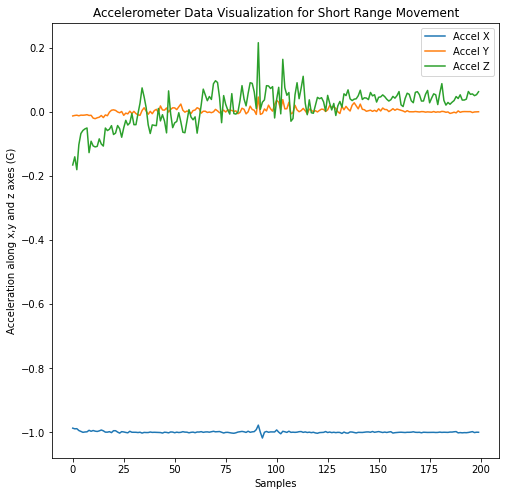

In [6]:
plt.rcParams["figure.figsize"] = [8, 8]
plt.title('Accelerometer Data Visualization for Short Range Movement')
plt.xlabel('Samples')
plt.ylabel('Acceleration along x,y and z axes (G)')
plt.plot(accel)
plt.legend(('Accel X', 'Accel Y', 'Accel Z'))
plt.show()

2. Plotting Gyroscope Data

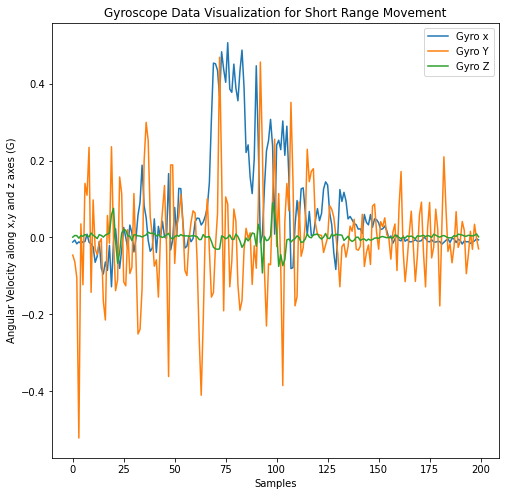

In [7]:
plt.title('Gyroscope Data Visualization for Short Range Movement')
plt.xlabel('Samples')
plt.ylabel('Angular Velocity along x,y and z axes (G)')
plt.plot(gyro)
plt.legend(('Gyro x', 'Gyro Y', 'Gyro Z'))
plt.show()

Determining the Number of Steps

In [8]:
vel = 0.97
val_calib = 0.5
velocity_init = [0,0,0]
position_init = [0,0,0]
steps = []
step_n = []
prev = -1
# print(gyro[:,0])
for i in range(len(gyro[:,0])):
    if gyro[i,0] > 0.1 and prev not in range(i-5,i): #and gyro[i,1] < -1.2: #or gyro[i,2] < -1.7:
        prev = i
        steps.append(gyro[i,0])
        step_n.append(i)

# print(len(steps))
print(step_n)
print('Total Number of Steps taken:',len(step_n))

dist_x = []
a =0
for i in step_n:
    # print(i)
    for j in range(0,i):
        if a not in dist_x:
            dxdt = vel + accel[j,0]*dt
            x = (dt*dxdt).cumsum()
            a = x
            dist_x.append(a)

[34, 47, 53, 67, 73, 79, 85, 91, 97, 103, 112, 123, 131]
Total Number of Steps taken: 13


Calculating Step-Wise Velocity and Distance by Calling Double Integration Function on each Step 



In [9]:
velocity_step = []
position_step = []
for i in range(0,len(step_n)):
  if i == 1:
    velocity, position, val = double_integration(accel[0:step_n[i],0]*9.8+9.8,accel[0:step_n[i],1]*9.8,accel[:step_n[i],2]*9.8, val_calib, velocity_init, position_init, delta_t)
    velocity_step.append(velocity)
    position_step.append(position)
  if i > 1:
    velocity, position, val = double_integration(accel[step_n[i-1]:step_n[i],0]*9.8+9.8,accel[step_n[i-1]:step_n[i],1]*9.8,accel[step_n[i-1]:step_n[i],2]*9.8, val_calib, velocity_init, position_init, delta_t)
    velocity_step.append(velocity)
    position_step.append(position)

# print(velocity_step)

Calculating Distance Travelled along Each Axis: X,Y and Z and Euclidean Distance in (Y-Z) plane

12
dx_step [-0.007883814457082725, -0.007618974558328126, -0.00681312376695597, -0.0058584969313500695, -0.005237168239805804, -0.004957958822298753, -0.0048584660753728665, -0.004764160746449013, -0.004506400556825552, -0.004084007582236339, -0.0036372493901472448, -0.0031949521534143308, -0.002814043976619908, -0.0024841193084239746, -0.002024423178629389, -0.0014501023987941817, -0.001030363773848306, -0.0008720647257290373, -0.0007799782728444404, -0.000687155045245409, -0.0005562409829862908, -0.00020966604385096177, 0.00017644411475829184, 0.0002777792512578094, 0.00022932964223581435, 0.0003003338958153341, 0.00040055345234932694, 0.0003772484352529649, 0.0003765043728344115, 0.0005044599325894064, 0.0005995020734156547, 0.0006179954275097087, 0.0006139282864179698, 0.0005939583582749283, 0.0005362566180829422, 0.00042345841851368273, 0.00033951069836828194, 0.00028625750818209953, 0.00026110834247712166, 0.00028699603052701524, 0.0003047471181580096, 0.00030511712295387076, 0.0

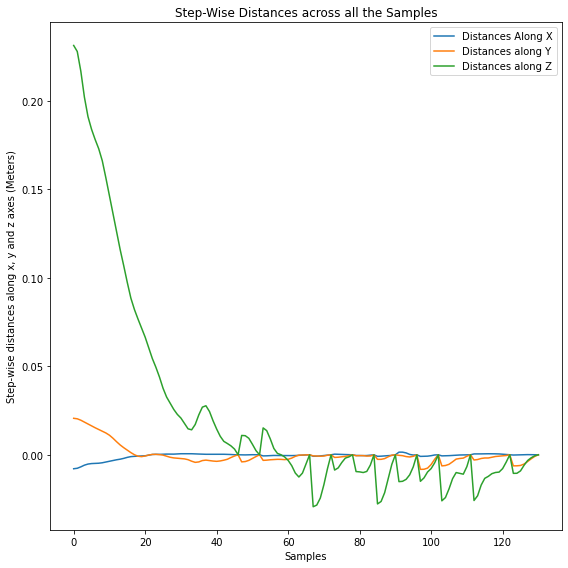

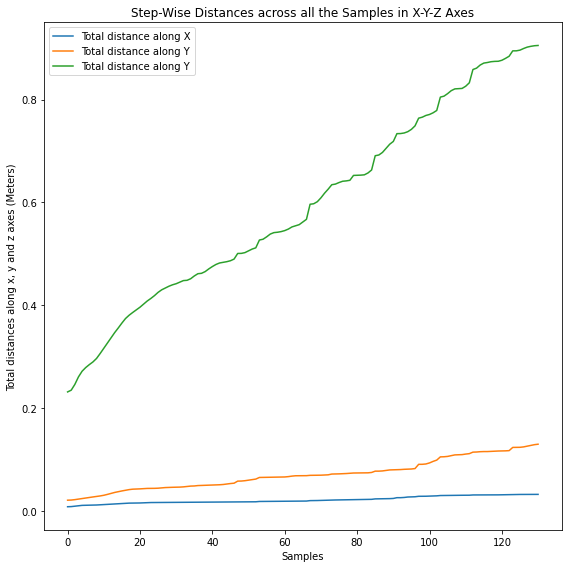

0.9055108887658707
0.9238125679785025


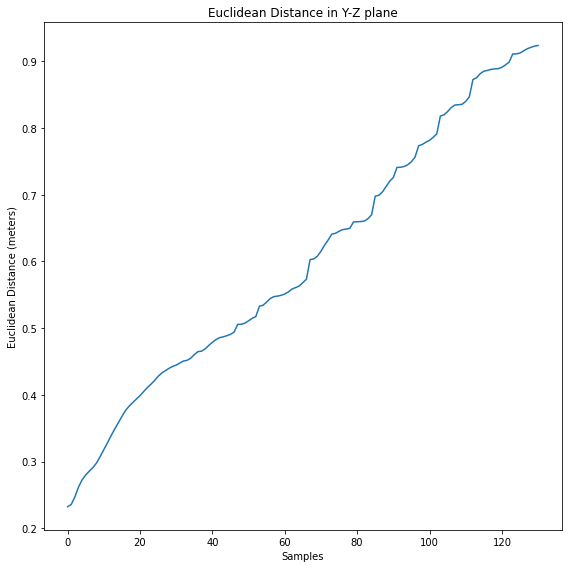

In [26]:
positions_x = []
positions_y = []
positions_z = []
for p in range(0,len(position_step)):
  positions_x.append(position_step[p][0])
  positions_y.append(position_step[p][1])
  positions_z.append(position_step[p][2])
print(len(positions_x))
dx_step = []
tot = 0
tot_dx = 0
toty = 0
dxt = []
tot_x = []

for x in range(0,len(positions_x)):
  # print(type(positions_x[x]))
  for i in range(0,len(positions_x[x])):
    dx = abs(positions_x[x][i] - positions_x[x][i-1])
    tot_dx += dx
    tot_x.append(tot_dx)

    dx2 = (positions_x[x][i] - positions_x[x][i-1])
    dxt.append(dx)
    tot += dx2
    dx_step.append(tot)

print('dx_step',dx_step)


dy_step = []
dyt = []
tot_y = []
tot_dy = 0

for y in range(0,len(positions_y)):
  # print(type(positions_y[y]))
  for j in range(0,len(positions_y[y])):
    dy = abs(positions_y[y][j] - positions_y[y][j-1])
    tot_dy += dy
    tot_y.append(tot_dy)
    dy2 = positions_y[y][j] - positions_y[y][j-1]
    dyt.append(dy)
    toty += dy2
    dy_step.append(toty)
totz = 0
dz_step = []
dzt = []
print('dz_step',dz_step)
tot_z = []
tot_dz = 0
for z in range(0,len(positions_z)):
  for k in range(0,len(positions_z[z])):
    dz = abs(positions_z[z][k] - positions_z[z][k-1])
    dz2 = positions_z[z][k] - positions_z[z][k-1]
    tot_dz += dz
    tot_z.append(tot_dz)
    dzt.append(dz2)
    totz += dz2
    dz_step.append(totz)


tote = 0
dz_step_eu = []
print('total distance------> along x: ', tot_dx, 'along y: ',tot_dy, 'along z: ',tot_dz)
# print(tot/len())
for z in range(0,len(positions_z)):
  for k in range(0,len(positions_z[z])):
    de = np.sqrt(np.square((positions_z[z][k] - positions_z[z][k-1]))+np.square((positions_y[z][k] - positions_y[z][k-1])))
    dzt.append(de)
    tote += de
    dz_step_eu.append(tote)

print("euclidean distance y-z: ", dz_step_eu)
plt.title('Step-Wise Distances across all the Samples')
plt.xlabel("Samples")
plt.ylabel("Step-wise distances along x, y and z axes (Meters)")
plt.plot(dx_step)
plt.plot(dy_step)
plt.plot(dz_step)
plt.legend(('Distances Along X','Distances along Y','Distances along Z'))
plt.show()

plt.title('Step-Wise Distances across all the Samples in X-Y-Z Axes')
plt.xlabel("Samples")
plt.ylabel("Total distances along x, y and z axes (Meters)")
plt.plot(tot_x)
plt.plot(tot_y)
plt.plot(tot_z)
plt.legend(('Total distance along X','Total distance along Y','Total distance along Y'))
plt.show()

print(tot_dz)
print(tote)




plt.title('Euclidean Distance in Y-Z plane')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distance (meters)')
plt.plot(dz_step_eu)
# plt.legend(('Euclidean Distance in Y-Z Plane'))
plt.show()

**II. Plotting Distance with Direction**

Getting Data

In [11]:
# yaw = np.loadtxt('/content/drive/MyDrive/dead_reckoning/straight/yaw_s.csv', delimiter=',')
# yaw = np.loadtxt('/content/drive/MyDrive/dead_reckoning/circle/yaw.csv', delimiter=',')
yaw = np.loadtxt('/content/drive/MyDrive/dead_reckoning/table/yaw3.csv', delimiter=',')
# yaw = np.loadtxt('/content/drive/MyDrive/dead_reckoning/rotate/yaw_ro.csv', delimiter=',')
# yaw = np.loadtxt('/content/drive/MyDrive/dead_reckoning/NINETY/yaw_90.csv', delimiter=',')

motion_r = np.loadtxt('/content/drive/MyDrive/dead_reckoning/table/motion_r.csv', delimiter=',')

Function for plotting Distance with Direction

In [12]:
def plot_point(start_point, yaw, length):
     x, y = start_point
     xs = []
     ys = []
     xys =[]
     xye = []

     for i in range(0,len(length)):
       if (i==0):
        startx = x
        starty = y
        endy = y + length[i] * math.sin(yaw[0])
        endx = length[i] * math.cos(yaw[0])
        xs.append([startx,endx])
        ys.append([starty,endy])
       if (i > 0):
        startx = endx
        starty = endy
        endy = y + length[i] * math.sin(yaw[i])
        endx = x + length[i] * math.cos(yaw[i])
        xs.append([startx,endx])
        ys.append([starty,endy])
        xys.append([startx,starty])
        xye.append([endx,endy])

     fig = plt.figure()
     ax = plt.subplot(111)
     ax.plot(xs,ys)
    #  plt.title('Plotting change in angles with Distance')
     plt.legend(('STARTING STEP DISTANCE','User Motion Trajectory'))
    #  ax.set_ylim([0, 20])   # set the bounds to be 10, 10
    #  ax.set_xlim([-10, 11])
     plt.xlabel("Y coordinates (meters)")
     plt.ylabel("Z coordinates (meters)")
     
     plt.rcParams["figure.figsize"] = [5, 5]
     plt.rcParams["figure.autolayout"] = True
     im = plt.imread("/content/drive/MyDrive/dead_reckoning/table.jpeg")
     fig, ax = plt.subplots()
     plt.xlabel("South-West")
     plt.ylabel("South-East")
     ax.plot(xs,ys)
    # plot_point((dy_step[0],dz_step[0]), poly_y3, dz_step_eu)
     im = ax.imshow(im, extent=[-0.1, 1.0, 0.1, 1.2])
     x = np.array(range(300))










Integrating Gyro data and getting change in Angles across all samples

In [13]:
dx_plot = dx_step
dy_plot = dy_step
angle =0.0

angles = []
yaw_angles = []
yaw_angle = 0.0
for i in range(0,len(gyro[:,0])):
  angle += gyro[i,0]*delta_t[i]
  angles.append(angle)
motion_ro = []
r = 0.0
for i in range(0,len(motion_r[:,0])):
  r += (motion_r[:,0][i]+motion_r[:,0][i-1])/2*delta_t[i]
  motion_ro.append(r)

# for i in range(0,len(yaw)):
#   yaw_angle = yaw[i] - yaw[i-1]
#   yaw_angles.append(yaw_angle)

print(angles)
yaw_plot = []
for i in range(0, len(step_n)):
  yaw_plot.append(motion_ro[step_n[i]])


[-0.000359646987889728, -0.0010255113032365548, -0.0026658213378775416, -0.003799480728949164, -0.005280546053813938, -0.006399549627269184, -0.007445260628439905, -0.006592459457480188, -0.007798316575311507, -0.009494236010118895, -0.011923511699061118, -0.018348710549558334, -0.02316882809694369, -0.024195863307204222, -0.03216495616517469, -0.0416080419470209, -0.04793420300475044, -0.05645727145341782, -0.05851434057032889, -0.07125081449880596, -0.0722198971407138, -0.06998354565738088, -0.07358072134543532, -0.08156264215839715, -0.08474419778010148, -0.08214955890056319, -0.08215546682456348, -0.08496025056460224, -0.08175297548203853, -0.08054338364120729, -0.0843028237443729, -0.08459358310877461, -0.0788188190408295, -0.06974250911678538, -0.05105512955371379, -0.0428349852340493, -0.03771738332359664, -0.038472735973598675, -0.04203935905106524, -0.044798725671259615, -0.03999571932173385, -0.043878611939293655, -0.04099954709863152, -0.041073580547469755, -0.03688668046090

Plotting
1. Yaw Axis Rotation Angles
2. Change in angle along x-axis by integrating Gyro X data
3. User motion_rotate rate of change in angle along X axis

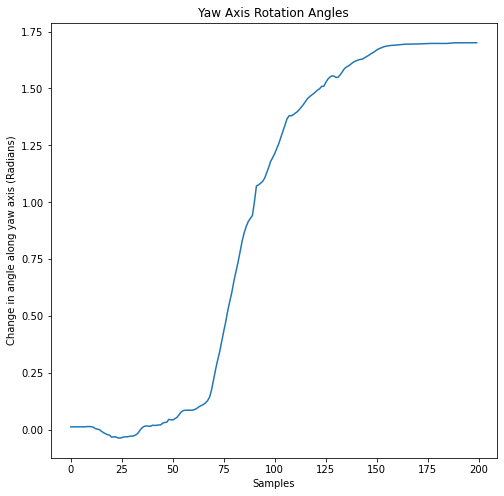

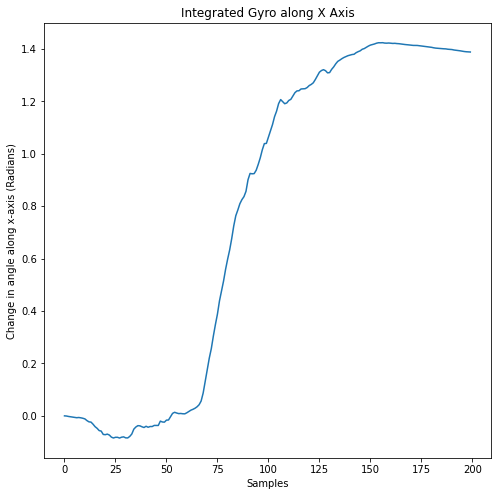

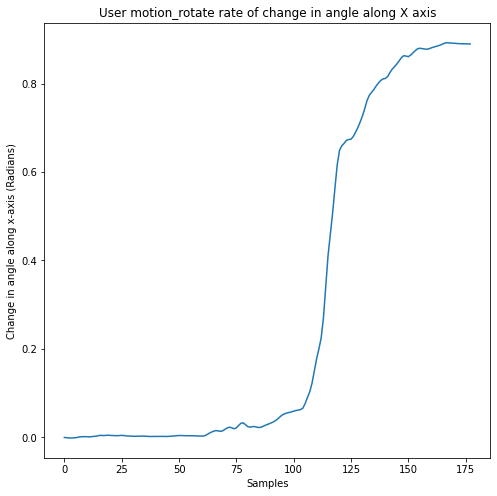

In [14]:
plt.title('Yaw Axis Rotation Angles')
plt.xlabel('Samples')
plt.ylabel('Change in angle along yaw axis (Radians)')
plt.plot(yaw)
plt.show()
plt.title('Integrated Gyro along X Axis')
plt.xlabel('Samples')
plt.ylabel('Change in angle along x-axis (Radians)')
plt.plot(angles)
plt.show()
plt.title('User motion_rotate rate of change in angle along X axis')
plt.xlabel('Samples')
plt.ylabel('Change in angle along x-axis (Radians)')
plt.plot(motion_ro)
plt.show()



Plotting Sample-Wise Direction along Distance: Movement Trajectory with Total Euclidean distance in (Y-Z) plane as the length of trajectory, along:
1. User motion_rotate rate of change in angle along X axis 
2. Change in angle along x-axis by integrating Gyro X data
3. Yaw Axis Rotation Angles

131
200


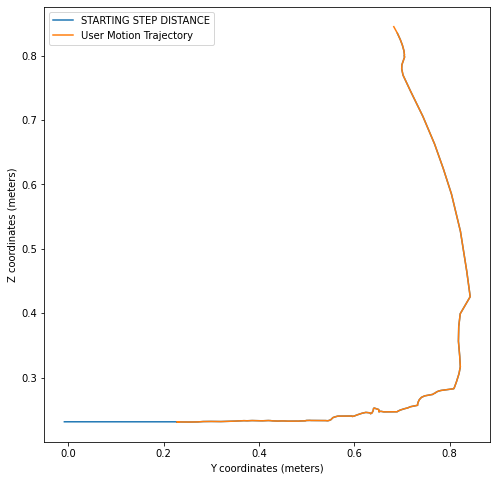

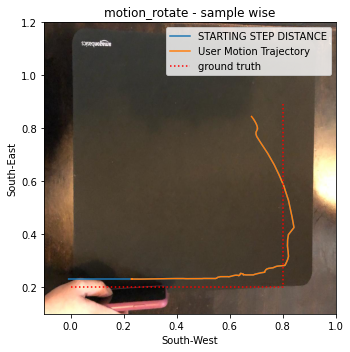

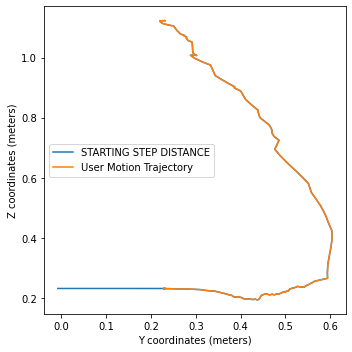

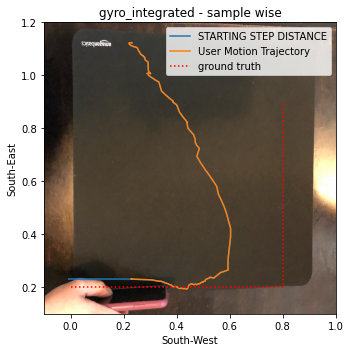

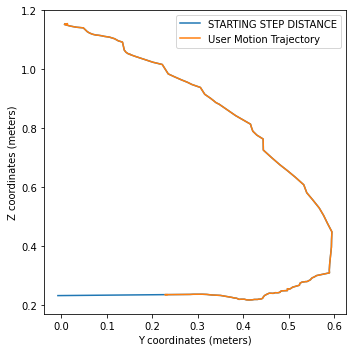

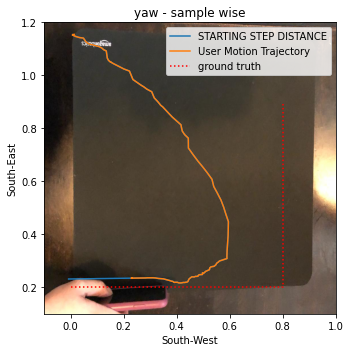

In [15]:
listx = [0,0.4,0.6,0.8,0.8]
listy = [0.2,0.2,0.2,0.2,0.9]
plot_point((dx_step[0],dz_step[0]), motion_ro, dz_step_eu)
plt.title('motion_rotate - sample wise')
plt.plot(listx,listy,ls = 'dotted', color = 'red')
plt.legend(('STARTING STEP DISTANCE','User Motion Trajectory','ground truth'))

plot_point((dx_step[0],dz_step[0]), angles, dz_step_eu)
plt.title('gyro_integrated - sample wise')
plt.plot(listx,listy,ls = 'dotted', color = 'red')
plt.legend(('STARTING STEP DISTANCE','User Motion Trajectory','ground truth'))

plot_point((dx_step[0],dz_step[0]), yaw, dz_step_eu)
plt.title('yaw - sample wise')
plt.plot(listx,listy,ls = 'dotted', color = 'red')
plt.legend(('STARTING STEP DISTANCE','User Motion Trajectory','ground truth'))
print(len(dx_plot))
print(len(yaw))


# fig = plt.figure()
# plt.plot(dy_plot)
# fig = plt.figure()
# plt.plot(dx_plot,dy_plot)

Plotting Step-Wise Direction along Distance: Movement Trajectory with Total Euclidean distance in (Y-Z) plane as the length of trajectory, along:

1. Yaw Axis Rotation Angles
2. Change in angle along x-axis by integrating Gyro X data
3. User motion_rotate rate of change in angle along X axis

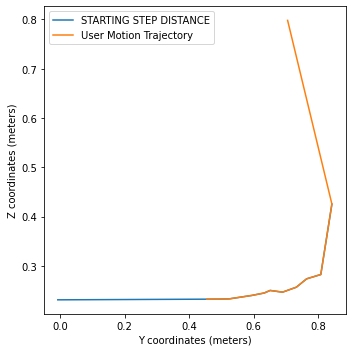

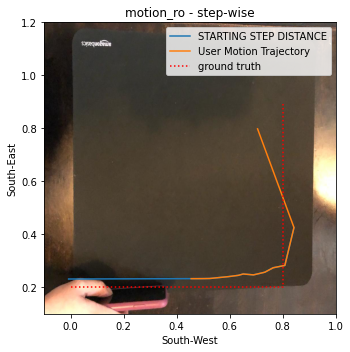

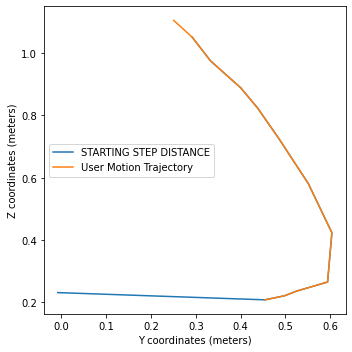

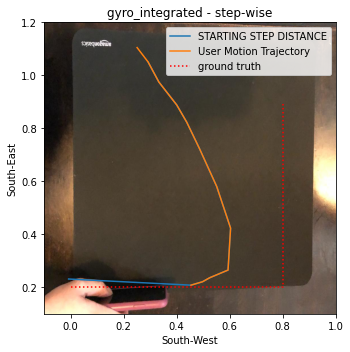

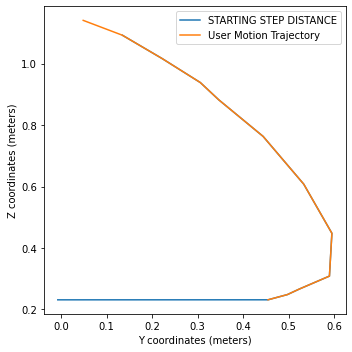

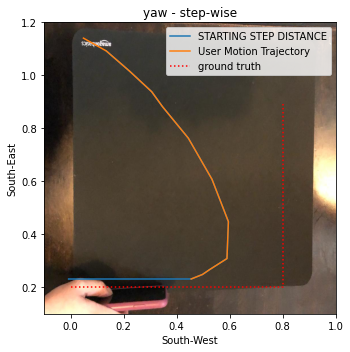

In [16]:
steps = []
index_x = []
# print(step_n)
for i in range(0,len(step_n)):
  # print(step_n[i])
  for j in range(0,len(dz_step_eu)):
    if step_n[i] == j:
      steps.append(dz_step_eu[int(j)])
      index_x.append(int(j))


# print(samples_x)
# print(index_x)
yaw_plots = []
gyro_plots = []
yaw_p = []
motionro_plots = []
for i in range(0, len(steps)):
  motionro_plots.append(motion_ro[index_x[i]])
for i in range(0, len(steps)):
  gyro_plots.append(angles[index_x[i]])
for i in range(0, len(steps)):
  yaw_plots.append(yaw[index_x[i]])


  # yaw_p.append((yaw[index_x[i]]+yaw[index_x[i-1]]+yaw[index_x[i-2]])/3)


plot_point((dx_step[0],dz_step[0]), motionro_plots, steps)
plt.title('motion_ro - step-wise')
plt.plot(listx,listy,ls = 'dotted', color = 'red')
plt.legend(('STARTING STEP DISTANCE','User Motion Trajectory','ground truth'))

plot_point((dx_step[0],dz_step[0]), gyro_plots, steps)
plt.title('gyro_integrated - step-wise')
plt.plot(listx,listy,ls = 'dotted', color = 'red')
plt.legend(('STARTING STEP DISTANCE','User Motion Trajectory','ground truth'))

plot_point((dx_step[0],dz_step[0]), yaw_plots, steps)
plt.title('yaw - step-wise')
plt.plot(listx,listy,ls = 'dotted', color = 'red')
plt.legend(('STARTING STEP DISTANCE','User Motion Trajectory','ground truth'))
# print(yaw_plots)
# print(np.array(yaw_plots) * (180/np.pi))
# print(np.array(gyro_plots) * (180/np.pi))
# print(samples_x)
# print(dz_step[0],dy_step[0])





      


Smoothening the yaw, gyro and motion_rotate curves using PolyFit

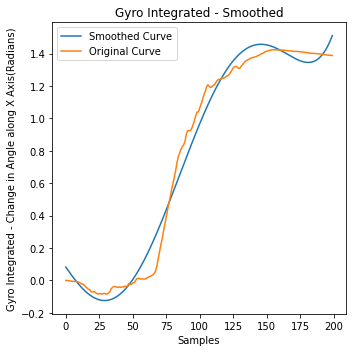

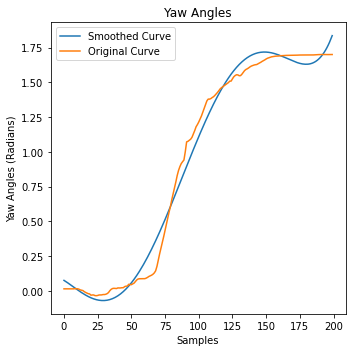

<Figure size 360x360 with 0 Axes>

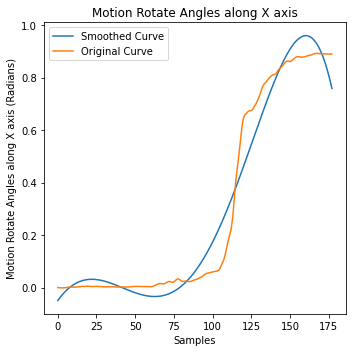

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# print(len(yaw))
points = []

for i in range(0,len(angles)):
  points.append(i)

plt.figure()
plt.title('Gyro Integrated - Smoothed')
plt.xlabel('Samples')
plt.ylabel('Gyro Integrated - Change in Angle along X Axis(Radians)')
poly1 = np.polyfit(points,angles,5)
poly_y1 = np.poly1d(poly1)(points)
plt.plot(points,poly_y1)
plt.plot(points,angles)
plt.legend(('Smoothed Curve','Original Curve'))
plt.show()

plt.figure()
plt.title('Yaw Angles')
plt.xlabel('Samples')
plt.ylabel('Yaw Angles (Radians)')
poly2 = np.polyfit(points,yaw,5)
poly_y2 = np.poly1d(poly2)(points)
plt.plot(points,poly_y2)
plt.plot(points,yaw)
plt.legend(('Smoothed Curve','Original Curve'))
plt.show()

pointsr = []

for i in range(0,len(motion_ro)):
  pointsr.append(i)

plt.figure()
plt.figure()
plt.title('Motion Rotate Angles along X axis')
plt.xlabel('Samples')
plt.ylabel('Motion Rotate Angles along X axis (Radians)')
poly3 = np.polyfit(pointsr,motion_ro,5)
poly_y3 = np.poly1d(poly3)(pointsr)
plt.plot(pointsr,poly_y3)
plt.plot(pointsr,motion_ro)

plt.legend(('Smoothed Curve','Original Curve'))
plt.show()

# print(len(poly_y))

Plotting Smoothed Sample-Wise Direction along Distance: Movement Trajectory with Total Euclidean distance in (Y-Z) plane as the length of trajectory, along:

1. Yaw Axis Rotation Angles
2. Change in angle along x-axis by integrating Gyro X data
3. User motion_rotate rate of change in angle along X axis

131


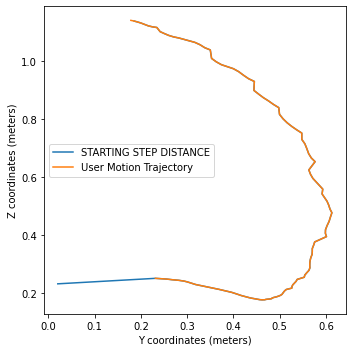

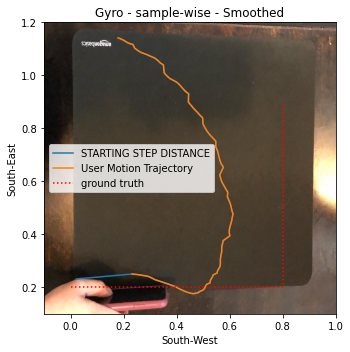

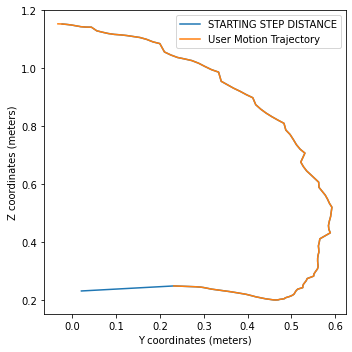

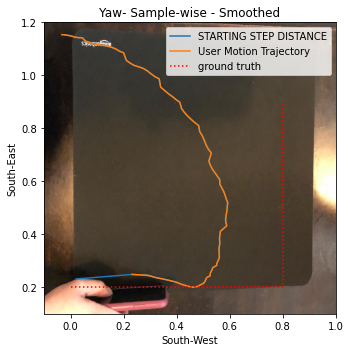

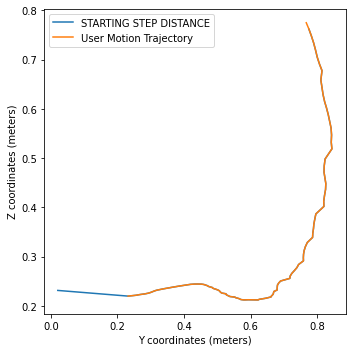

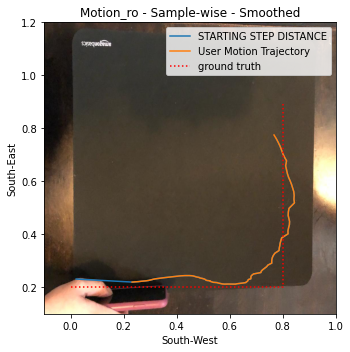

In [18]:
plot_point((dy_step[0],dz_step[0]), poly_y1, dz_step_eu)
plt.title('Gyro - sample-wise - Smoothed')
plt.plot(listx,listy,ls = 'dotted', color = 'red')
plt.legend(('STARTING STEP DISTANCE','User Motion Trajectory','ground truth'))

plot_point((dy_step[0],dz_step[0]), poly_y2, dz_step_eu)
plt.title('Yaw- Sample-wise - Smoothed')
plt.plot(listx,listy,ls = 'dotted', color = 'red')
plt.legend(('STARTING STEP DISTANCE','User Motion Trajectory','ground truth'))

plot_point((dy_step[0],dz_step[0]), poly_y3, dz_step_eu)
plt.title('Motion_ro - Sample-wise - Smoothed')
plt.plot(listx,listy,ls = 'dotted', color = 'red')
plt.legend(('STARTING STEP DISTANCE','User Motion Trajectory','ground truth'))
# print(len(poly_y))
print(len(dz_step_eu))

**Experiment 2 - Walking in an Empty Space and getting the Trajectory**

In [19]:
# fpaths = ['/content/drive/MyDrive/dead_reckoning/new_walk_shoe/gyro.csv', '/content/drive/MyDrive/dead_reckoning/new_walk_shoe/accel.csv', '/content/drive/MyDrive/dead_reckoning/new_walk_shoe/accel_time.csv']
# fpaths = ['/content/drive/MyDrive/dead_reckoning/walk_pocket/gyro.csv', '/content/drive/MyDrive/dead_reckoning/walk_pocket/accel.csv', '/content/drive/MyDrive/dead_reckoning/walk_pocket/time_acc.csv']
fpaths = ['/content/drive/MyDrive/dead_reckoning/new_walk2/gyro.csv', '/content/drive/MyDrive/dead_reckoning/new_walk2/accel.csv', '/content/drive/MyDrive/dead_reckoning/new_walk2/accel_time.csv']

# fpaths = ['/content/drive/MyDrive/dead_reckoning/rotate/gyro_ro.csv', '/content/drive/MyDrive/dead_reckoning/rotate/accel_ro.csv', '/content/drive/MyDrive/dead_reckoning/rotate/accel_time_ro.csv']
# fpaths = ['/content/drive/MyDrive/dead_reckoning/circle/gyro.csv', '/content/drive/MyDrive/dead_reckoning/circle/accel.csv', '/content/drive/MyDrive/dead_reckoning/circle/time.csv']
# fpaths = ['/content/drive/MyDrive/dead_reckoning/straight/gyro_.csv', '/content/drive/MyDrive/dead_reckoning/straight/accel.csv', '/content/drive/MyDrive/dead_reckoning/straight/time.csv']
# fpaths = ['/content/drive/MyDrive/dead_reckoning/NINETY/gyro.csv', '/content/drive/MyDrive/dead_reckoning/NINETY/accel.csv', '/content/drive/MyDrive/dead_reckoning/NINETY/time.csv']



gyro,accel, timestamp_acc= load_data(*fpaths)
# print(timestamp_acc[0])
# print(val)
delta_t = [0.030210768]
for i in range(0,len(timestamp_acc)-1):
    dt = timestamp_acc[i+1] - timestamp_acc[i]
    delta_t.append(dt)
for i in range(0,len(accel)-2):
    # accel[i][1] += (accel[i-2][1]+accel[i-1][1]+accel[i+1][1])/3
    if accel[i][0] > -0.2 and accel[i][0] < 0.2:
        accel[i][0] = 0

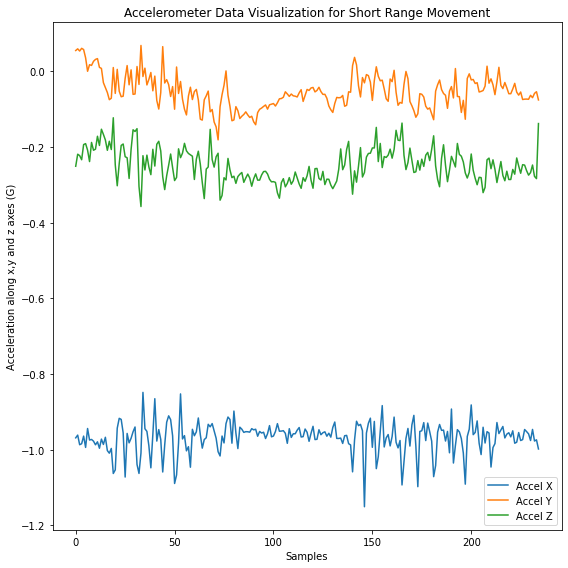

In [20]:
plt.rcParams["figure.figsize"] = [8, 8]
plt.title('Accelerometer Data Visualization for Short Range Movement')
plt.xlabel('Samples')
plt.ylabel('Acceleration along x,y and z axes (G)')
plt.plot(accel)
plt.legend(('Accel X', 'Accel Y', 'Accel Z'))
plt.show()

**Drift Reduction**

Discrete Fourier Transform

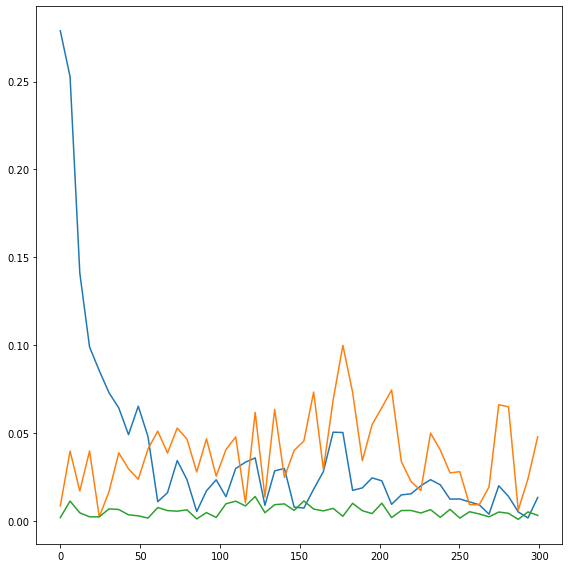

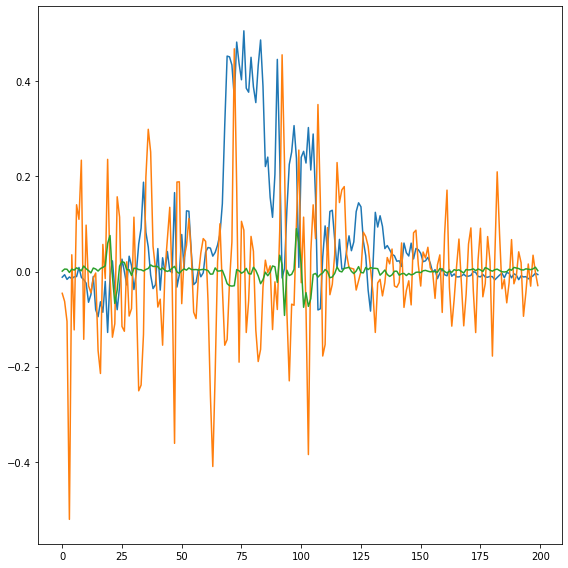

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack

# Number of sample points

motion_r = np.loadtxt('/content/drive/MyDrive/dead_reckoning/table/gyro.csv', delimiter=',')



N = 100
# sample spacing
T = 1.0 / 600
x = np.linspace(0.0, N*T, N)
yf = scipy.fftpack.fft(motion_r[:,0])
yf2 = scipy.fftpack.fft(motion_r[:,1])      #y
yf3 = scipy.fftpack.fft(motion_r[:,2])  
# yf4 = scipy.fftpack.ifft(motion_r[:,2])    #z
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots()

plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(yf2)

plt.plot(xf, 2.0/N * np.abs(yf2[:N//2]))
plt.plot(xf, 2.0/N * np.abs(yf3[:N//2]))

plt.show()
plt.plot(motion_r)
# plt.plot(xf, 2.0/N * np.abs(yf4[:N//2]))
# plt.show()
# plt.plot(motion_r[:,2])
plt.show()